In [1]:
# load in the modules
import pandas as pd
from itertools import combinations
from os import mkdir

import geopandas
# additionally requires rtree for a geopandas function
import matplotlib.pyplot as plt

# set input file name to a variable (presumably in same directory as this script)
fn = "merged_dataset.csv"

mapping_output_dir = "./pairwise_output/mapping/"

In [2]:
# read in the dataframe
df = pd.read_csv(fn)

# unnamed columns appear to be manually placed for visual organiation, remove them
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# collectionCode is being used to hold the unique concepts
concepts = df['collectionCode'].unique().tolist()
# catalogNumber is the ID for each occurence
occurences = df['catalogNumber'].unique().tolist()

<Figure size 432x288 with 0 Axes>

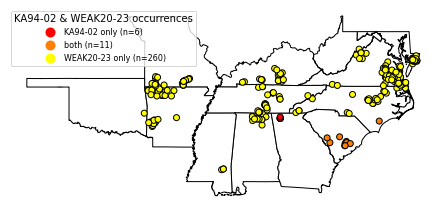

<Figure size 432x288 with 0 Axes>

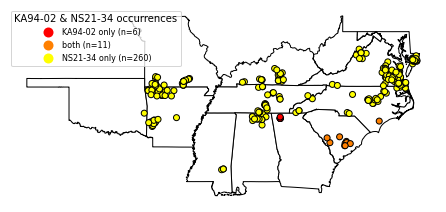

<Figure size 432x288 with 0 Axes>

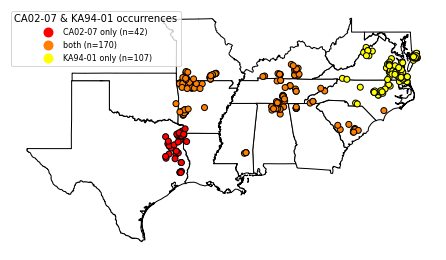

<Figure size 432x288 with 0 Axes>

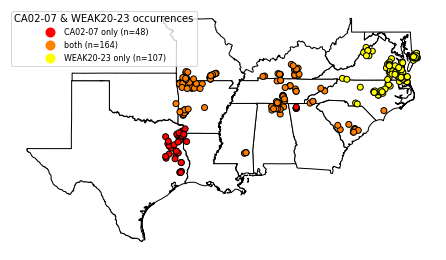

<Figure size 432x288 with 0 Axes>

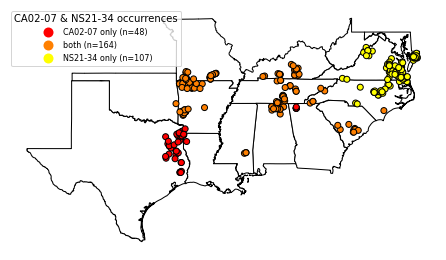

<Figure size 432x288 with 0 Axes>

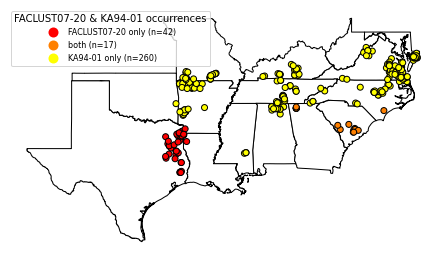

<Figure size 432x288 with 0 Axes>

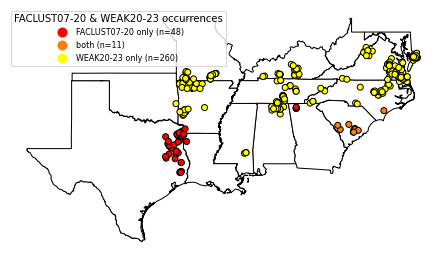

<Figure size 432x288 with 0 Axes>

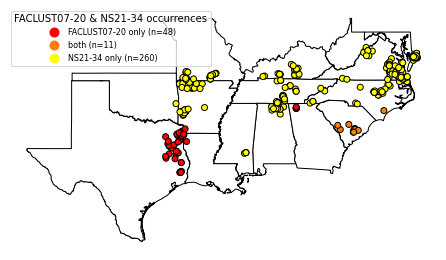

In [3]:
# create a container to hold the analysis summary
col_names = ["A_code", "B_code", "A/b", "B/a", "A*B"]
analysis_summary = pd.DataFrame(columns = col_names)

# create a container to hold the overlapping matrix
col_names = [x.replace(":", "-") for x in df["collectionCode"].unique()]
combination_counts = pd.DataFrame(columns = col_names)

# state shape file from:
#    https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
state_shp = geopandas.read_file("./ref/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

# establish a destination subfolder for geopackage
try:
    mkdir(mapping_output_dir)
except FileExistsError:
    pass

state_shp.to_file(f"{mapping_output_dir}pairwise_package.gpkg",
                  layer='states',
                  driver="GPKG")

# iterate over each pair among all unique concepts
for concept_a, concept_b in combinations(concepts, 2):

    a_occurences = df[df["collectionCode"] == concept_a]
    a_code = a_occurences["collectionCode"].unique()[0].replace(":", "-")
    
    b_occurences = df[df["collectionCode"] == concept_b]
    b_code = b_occurences["collectionCode"].unique()[0].replace(":", "-")
    
    # use merge for inner join. However, this duplicates all columns other than catalogNumber
    # since that data is mostly duplicated, drop the right column names
    # this does leave left column data in the concept specific fields (i.e., scientificName)
    combined_occurences = pd.merge(a_occurences, b_occurences, how='inner',
                                   on=['catalogNumber'],
                                   suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

    # count the overlapping occurences among the two concepts
    overlap_count = combined_occurences.shape[0]
    #########
    # count A not in B (A/b) & B not in A (B/a)
    a_cat_nums = a_occurences['catalogNumber'].unique().tolist()
    b_cat_nums = b_occurences['catalogNumber'].unique().tolist()

    # identify exclusive catalognumbers
    a_exclusives = [x for x in a_cat_nums if x not in b_cat_nums]
    b_exclusives = [x for x in b_cat_nums if x not in a_cat_nums]
    
    # identify overlapping catalog numbers
    combined_cat_nums = combined_occurences['catalogNumber'].unique().tolist()
    overlap_cat_nums = [x for x in combined_cat_nums if x not in a_exclusives or x not in b_exclusives]
    
    # make a dataframe holding the overlapping & exclusive occurences
    overlap_occurences = combined_occurences.loc[combined_occurences['catalogNumber'].isin(overlap_cat_nums)].copy()
    overlap_alignment = f"both (n={overlap_count})"
    overlap_occurences["alignment"] = overlap_alignment
    
    a_exec_occurences = a_occurences.loc[a_occurences['catalogNumber'].isin(a_exclusives)].copy()
    a_exec_alignment = f"{a_code} only (n={len(a_exclusives)})"
    a_exec_occurences["alignment"] = a_exec_alignment
    
    b_exec_occurences = b_occurences.loc[b_occurences['catalogNumber'].isin(b_exclusives)].copy()
    b_exec_alignment = f"{b_code} only (n={len(b_exclusives)})"
    b_exec_occurences["alignment"] = b_exec_alignment

    # container to hold a more succinct dataframe with overlaps & exclusives
    gdf_rows = pd.DataFrame(columns=["scientificName", "collectionCode", "catalogNumber",
                                     "decimalLatitude", "decimalLongitude",
                                     "alignment"])

    gdf_rows = pd.concat([gdf_rows, a_exec_occurences, overlap_occurences, b_exec_occurences], join="inner")
    # convert the alignment column to an ordered categorical type for proper plotting
    cat_list = [a_exec_alignment,
               overlap_alignment,
               b_exec_alignment]
    #from pandas.api.types import CategoricalDtype
    cat_type = pd.api.types.CategoricalDtype(categories=cat_list, ordered=True)
    gdf_rows['alignment'] = gdf_rows['alignment'].astype(cat_type)

    #  load the lat/lon as geopoints
    geoPoints = geopandas.points_from_xy(gdf_rows['decimalLongitude'], gdf_rows['decimalLatitude'])

    # generate a GeoDataFrame using the df & geoPoints
    gdf = geopandas.GeoDataFrame(gdf_rows, geometry=geoPoints).set_crs("EPSG:4269")

    is_interesting = ( len(a_exclusives) * len(b_exclusives) * overlap_count ) > 0
    if is_interesting:

        # identify which state polygons contain a point of interest
        polygons_contains = geopandas.sjoin(state_shp, gdf, op='contains')
        # build a keep list of state names based on those polygons
        keep_states = polygons_contains["NAME"].unique().tolist()
        states = state_shp[state_shp["NAME"].isin(keep_states)]

        fig = plt.figure()
        ax = states.plot(color='white', edgecolor='black')
        ax.axis("off")
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        gdf.plot(ax=ax,
                 c="alignment",
                 cmap="autumn",
                 column="alignment",
                 categorical=True,
                 legend=True,
                 legend_kwds={'loc': "upper left",
                              'fontsize' : 8,
                              'title': f"{a_code} & {b_code} occurrences"},
                 edgecolors='k')

        # force a tight layout
        img_fn = f"{mapping_output_dir}{a_code}_{b_code}.png"
        plt.savefig(img_fn, dpi=300, pad_inches=0)

    # gpkg does not recognize the custom ordered categorical datatype so revert it to a string
    gdf['alignment'] = gdf['alignment'].astype("str")
    # write out the pairwise relationship to a geopackage layer
    gdf.to_file(f"{mapping_output_dir}pairwise_package.gpkg",
                layer=f'{a_code}_{b_code}',
                driver="GPKG")